In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import dateparser
from pytz import timezone
import shutil
import datetime

# SeaGrant-TA_DIC-MassBayData Concatentation

In [5]:
sheet2017 = pd.read_excel('../data/SeaGrant-TA_DIC-MassBayData/ToRies_Labprocessed2017sharedSeaGlass.xlsx',
                          sheet_name=None)

sheet2018 = pd.read_excel('../data/SeaGrant-TA_DIC-MassBayData/ToRies_Labprocessed2018_sharedSeaGlass.xlsx',
                          sheet_name=None)

sheet2019 = pd.read_excel('../data/SeaGrant-TA_DIC-MassBayData/ToRies_Labprocessed2019_sharedSeaGlass.xlsx',
                          sheet_name=None)

sheet20202021 = pd.read_excel('../data/SeaGrant-TA_DIC-MassBayData/ToRies_Labprocessed2020and2021_sharedSeaGlass.xlsx',
                          sheet_name=None)

In [6]:
data2017 = sheet2017['batch_all2017p']
metadata2017 = sheet2017['readme']

data2018 = sheet2018['batch_all2018p']
metadata2018 = sheet2018['readme']

data2019 = sheet2019['batch_all2019p']
metadata2019 = sheet2019['readme2019']

data20202021 = sheet20202021['batch12_13_14']
metadata20202021 = sheet20202021['readme']

### Fix datetime issues 2017

In [7]:
# Convert 2017 data to datetime
for ind, row in data2017.iterrows():
    date_val = row['SampleDateTime']
    if type(date_val) == str:
        date = dateparser.parse(date_val)
        try:
            x = date.strftime("%Y")
            if x != "2017":
                print(date_str)
        except:
            print(date_str)
        data2017.loc[ind, 'SampleDateTime'] = date

/Users/becklabash/opt/anaconda3/lib/python3.7/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


### Fix datetime issues 2018

In [8]:
# Reformat unrecognized strings (2018)
for ind, row in data2018.iterrows():
    if isinstance(row['SampleDateTime'], str):
        s = row['SampleDateTime']
        if (s[4] != " " and s[2] != " "):
            new_string = s[0:4] + " " + s[4:6] + " " + s[6:]
            data2018.loc[ind, 'SampleDateTime'] = new_string

# Convert reformated strings to datetime (2018)
for ind, row in data2018.iterrows():
    val = row['SampleDateTime']
    if isinstance(val, str):
        date = dateparser.parse(val)
        data2018.loc[ind, 'SampleDateTime'] = date

### Fix datetime issues 2019

In [9]:
#Convert 2019 data from pandas timestamp to datetime
#data2019['SampleDateTime'] = [date.to_pydatetime() for date in data2019['SampleDateTime']]
for ind, row in data2019.iterrows():
    data2019.loc[ind, 'SampleDateTime'] = row['SampleDateTime'].to_pydatetime()

### Fix datetime issues 2020-2021

In [10]:
for ind, row in data20202021.iterrows():
  # If the date is a pandas timestamp, convert to datetime
  if isinstance(row['PROF_DATE_TIME_LOCAL'], pd.Timestamp):
    data20202021.loc[ind, 'PROF_DATE_TIME_LOCAL'] = row['PROF_DATE_TIME_LOCAL'].to_pydatetime()
  # If the date is a string, convert to datetime
  elif isinstance(row['PROF_DATE_TIME_LOCAL'], str):
    data20202021.loc[ind, 'PROF_DATE_TIME_LOCAL'] = dateparser.parse(row['PROF_DATE_TIME_LOCAL'])

In [11]:
column_conversion = {'BottleLabel': 'Station_D',
                      'EVENT_ID': 'SampleID',
                      'STAT_ID': 'StationID',
                      'PROF_DATE_TIME_LOCAL': 'SampleDateTime',
                      'LATITUDE': 'Latitude',
                      'LONGITUDE': 'Longitude',
                      'DEPTH (m)': 'Depth',
                      'CONDTVY (mS/cm)': 'Conductivity',
                      'DO_RAW (mg/L)': 'Dissolved Oxygen (Model 43)',
                      'FLU_RAW (ug/L)': 'Chla Fluor',
                      'PCT_SAT_RAW (PCT)': 'DO % Saturation',
                      'pH ()': 'pH <2>',
                      'SAL (PSU)': 'Salinity',
                      'SIGMA_T ()': 'Sigma-T',
                      'TEMP (C)': 'Temperature',
                      'TRANS (m-1)': 'Beam Attenuation',
                      'AT': 'TA in (mmol/kgSW)',
                      'CT': 'TCO2 in (mmol/kgSW)'
                      }
for col in column_conversion:
    data20202021[column_conversion[col]] = data20202021[col]
    # Remove the old column
    data20202021.drop(col, axis=1, inplace=True)
# Remove sampling code column
data20202021.drop('Unnamed: 7', axis=1, inplace=True)

In [12]:
# Add data source to 20202021
data20202021['Data Source'] = 'ToRies_Labprocessed2020and2021_sharedSeaGlass'

### 

### Validate columns and concatenate

In [13]:
intersection = set(data2017.columns).intersection(set(data2018.columns)).intersection(set(data2019.columns)).intersection(set(data20202021.columns))
union = set(data2017.columns).union(set(data2018.columns)).union(set(data2019.columns)).union(set(data20202021.columns))

In [14]:
for col in union:
    if col not in intersection:
        print(col)

Sampling Date
Salinity - Carolina
Field Replicate
Sampling T
Salinity - Ries 
Sampling Depth
Pressure
Air Irradiance
Comments
VINDTA Sample Name
Sampled Bottle Name
Run T
Water Irradiance


In [15]:
concat = pd.concat([data2017, data2018, data2019, data20202021], sort=False, ignore_index=True)
# Drop microseconds and change timzeone to eastern
eastern = timezone('US/Eastern')
concat['SampleDateTime'] = [date.replace(microsecond=0).replace(tzinfo=eastern) for date in concat['SampleDateTime']]

#Convert to excel parsable string
concat['SampleDateTime'] = [date.strftime("%Y-%m-%d %H:%M:%S%z") for date in concat['SampleDateTime']]

In [24]:
concat = pd.read_csv('../data/SeaGrant-TA_DIC-MassBayData/concat/ToRies_Labprocessed2017_to_2021.csv')

In [25]:
# Inject val qual column into mwra batch
# Get all non-null 

# Iterate over the rows with a val_qual defined
for ind, row in concat.iterrows():

  # Get comparator columns
  depth = row['Depth']
  time = row['SampleDateTime']
  
  # Get matching row in mwra batch
  match_row = concat[
    (concat['Depth'] == depth)
  & (concat['SampleDateTime'] == time)]

  if (len(match_row) == 2):
    print(row['StationID'])
    inds = list(match_row.index.values)
    concat.loc[inds[0], 'Field Replicate'] = 'Y'
    concat.loc[inds[1], 'Field Replicate'] = 'Y'
    
  if (len(match_row) == 1):
    pass

  if (len(match_row) > 2):
    print("ERROR")

F22
F22
F22
F22
F22
F22
F22
F22
F22
F22
F22
F22
C2
C2
H2
H2
C2
C2
F22
F22
N01
N01
F22
F22
N01
N01
N01
F22
F22
N01
SG1
SG1
SG1
SG1
F22
F22
SG1
SG1
N15
N15
N12
N12
C1
C1
C2
C2
C03
C03
C07
C07
SG1
SG1
124
124
F22
F22
N01
N01
SG1
SG1
124
124
SG1
SG1
124
124
SG1
SG1
N01
N01
F22
F22
N01
N01
F22
F22
SG1
SG1
N01
N01
F22
F22
SG1
SG1
N01
N01
F22
F22
SG1
SG1
F22
F22
N01
N01
F22
F22
N01
N01
SG1
SG1
F22
F22
N01
N01
HAR
HAR
F22
F22
N01
N01
F22
F22
N01
N01
HAR
HAR
NFAL
NFAL
HAR
HAR
HAR
HAR
HAR
HAR
NFAL
NFAL
 F22
 F22
 N01
 N01
 F22
 F22
 N01
 N01
HAR
HAR
NFAL
NFAL
HAR
HAR
NFAL
NFAL


In [27]:
# Strip station ID spaces
#concat['STAT_ID'] = [stat.strip(" ") for stat in concat['STAT_ID']]
for ind, row in concat.iterrows():
    if type(row['StationID']) == str:
        concat.loc[ind, 'StationID'] = row['StationID'].strip(" ")

# Add S identifier to Stellwagen bank station IDs
for ind, row in concat.iterrows():
  if row['SampleID'] == 'SBNMS':
    concat.loc[ind, 'StationID'] = 'S' + row['StationID']

In [ ]:
concat.columns

In [29]:
concat.to_csv("../data/SeaGrant-TA_DIC-MassBayData/concat/ToRies_Labprocessed2017_to_2021_test.csv", index=False)

#### Convert metadata to text files

In [29]:
def df_to_txt(df, txt_file):
    row_arr = []
    for ind, row in df.iterrows():
        cell_arr = []
        for cell in row:
            if str(cell) == 'nan':
                cell_arr.append(" ")
            else:
                cell_arr.append(str(cell))

        row_arr.append(" ".join(cell_arr))
    out = "\n".join(row_arr)
    text_file = open(txt_file, "w")
    n = text_file.write(out)
    text_file.close()

In [30]:
df_to_txt(metadata2017,
          '../data/SeaGrant-TA_DIC-MassBayData/concat/metadata/ToRies_Labprocessed2017sharedSeaGlass_metadata.txt')
df_to_txt(metadata2018,
          '../data/SeaGrant-TA_DIC-MassBayData/concat/metadata/ToRies_Labprocessed2018_sharedSeaGlass_metadata.txt')
df_to_txt(metadata2019,
         '../data/SeaGrant-TA_DIC-MassBayData/concat/metadata/ToRies_Labprocessed2019_sharedSeaGlass_metadata.txt')
df_to_txt(metadata20202021,
'../data/SeaGrant-TA_DIC-MassBayData/concat/metadata/ToRies_Labprocessed2020and2021_sharedSeaGlass_metadata.txt')

# MWRA/MassBay Data Concatenation

### OldFormat Concatenation (2017 - 2019)

In [27]:
data_dir = '../data/MassBay/OldFormat/'

In [28]:
blacklist = []
# check that each excel file in the data_dir has only one sheet, add to blacklist if not
for file in os.listdir(data_dir):
    if file.endswith('.xlsx'):
        df = pd.read_excel(data_dir + file, sheet_name=None)
        if len(df) != 1:
            print('ERROR:', file, 'has', len(df), 'sheets')
            blacklist.append(file)

ERROR: WN172 event dataMarch2017.xlsx has 4 sheets
ERROR: WN173 sensor dataApril2017.xlsx has 3 sheets
ERROR: WN177 Event dataAug2017.xlsx has 2 sheets


In [29]:
# import the first sheet as a dataframe from non-blacklisted every excel file in data_dir
csvs = {}
files = os.listdir(data_dir)
for file in files:
    if file.endswith('.xlsx') and file not in blacklist:
        df = pd.read_excel(data_dir + file, sheet_name=0)
        csvs[file] = df

In [30]:
# Handle Special case: April2017
april2017 = 'WN173 sensor dataApril2017.xlsx'
df = pd.read_excel(data_dir + april2017, sheet_name=0)
csvs[april2017] = df

In [31]:
# Handle Special case: March2017
march2017 = 'WN172 event dataMarch2017.xlsx'
df = pd.read_excel(data_dir + march2017, sheet_name=0)
csvs[march2017] = df

In [32]:
# Handle Special case: Aug2017
aug2017 = 'WN177 Event dataAug2017.xlsx'
df = pd.read_excel(data_dir + aug2017, sheet_name=0)
csvs[aug2017] = df

In [33]:
# Correct insignificant column inconsistency in June 2018 data
june2018 = 'WN185 Event dataJune2018.xlsx'
cols_to_drop = []
columns = set(list(csvs.values())[0].columns)
for col in csvs[june2018].columns:
    if col not in columns:
        cols_to_drop.append(col)
csvs[june2018] = csvs[june2018].drop(columns=cols_to_drop)

In [34]:
# check that all elements of csvs have the same columns
columns = set(list(csvs.values())[0].columns)
print(columns)
for item in csvs.items():
  if columns != set(item[1].columns):
        print("ERROR: Column inconsistency in :" +item[0]) # error  if not all elements of csvs have the same columns (should be the same)
        break

{'Longitude', 'Beam Attenuation', 'Chla Fluor', 'Dissolved Oxygen (Model 43)', 'pH <2>', 'Water Irradiance', 'Depth', 'Temperature', 'Salinity', 'DO % Saturation', 'Sigma-T', 'Conductivity', 'StationID', 'SampleID', 'Latitude', 'Air Irradiance', 'SampleDateTime'}


In [35]:
# Save old format csvs
for csv in csvs:
    csvs[csv].to_csv(data_dir+'csv/'+csv+".csv", index = False)

In [36]:
# concatenate all csvs into one dataframe and save as csv
csv_list = list(csvs.values())
df = pd.concat(csv_list, ignore_index=True)

#add data source column
#df['Data Source'] = 'MassBay_2017_to_2019_CONCAT'

#df.to_csv('../data/MassBay/OldFormat/concat/MassBay_2017_to_2019_CONCAT.csv', index = False)

In [60]:
# Create metadata file for Old Format Concatenation
df = pd.DataFrame()
df.to_csv('../data/MassBay/OldFormat/concat/metadata/MassBay_2017_to_2019_CONCAT_metadata.csv', index = False)

In [37]:
df['StationID'] = [stat.strip(" ") for stat in df['StationID']]

all_stations = list(set(df['StationID']))
                    
                                   
x = 0
for station in all_stations:
    years = {'2017': 0, '2018': 0, '2019': 0,}
    for ind, row in df.iterrows():
        if row['StationID'] == station:
            years[row['SampleDateTime'].strftime("%Y")] += 1
    x += sum(list(years.values()))
    print(station, years)
print(x)

AF4 {'2017': 0, '2018': 0, '2019': 4}
N04 {'2017': 40, '2018': 50, '2019': 45}
N10 {'2017': 0, '2018': 0, '2019': 4}
F06 {'2017': 40, '2018': 50, '2019': 45}
F13 {'2017': 40, '2018': 50, '2019': 45}
N07 {'2017': 40, '2018': 50, '2019': 45}
F23 {'2017': 40, '2018': 50, '2019': 45}
N21 {'2017': 40, '2018': 50, '2019': 45}
F15 {'2017': 40, '2018': 50, '2019': 45}
N01 {'2017': 40, '2018': 50, '2019': 45}
N18 {'2017': 40, '2018': 50, '2019': 45}
F22 {'2017': 40, '2018': 50, '2019': 45}
F10 {'2017': 40, '2018': 50, '2019': 45}
1493


### New Format Concatenation (2020-)

#### Unit validation (not final concatenation)

In [195]:
data_dir = '../data/MassBay/NewFormat/'

In [196]:
blacklist = []
# check that each excel file in the data_dir has only one sheet, add to blacklist if not
for file in os.listdir(data_dir):
    if file.endswith('.xlsx'):
        df = pd.read_excel(data_dir + file, sheet_name=None)
        if len(df) != 1:
            print('ERROR:', file, 'has', len(df), 'sheets')
            blacklist.append(file)

In [197]:
# import the first sheet as a dataframe from non-blacklisted every excel file in data_dir
newcsvs = {}
files = os.listdir(data_dir)
for file in files:
    if file.endswith('.xlsx') and file not in blacklist:
        df = pd.read_excel(data_dir + file, sheet_name=0)
        newcsvs[file] = df

In [198]:
# 2020 -> 2021
#DO_RAW (mg/L) -> DISS_OXYGEN (mg/L)

# PCT_SAT_RAW (PCT) -> PCT_SAT (PCT) 
for csv in newcsvs:
    if 'DO_RAW (mg/L)' in newcsvs[csv].columns:
        newcsvs[csv]['DISS_OXYGEN (mg/L)'] = newcsvs[csv]['DO_RAW (mg/L)']
    if 'PCT_SAT_RAW (PCT)' in newcsvs[csv].columns:
        newcsvs[csv]['PCT_SAT (PCT)'] = newcsvs[csv]['PCT_SAT_RAW (PCT)']
        
# Check that important columns are the same
intersection = set(list(newcsvs.values())[0].columns)
for csv in newcsvs:
    intersection = intersection.intersection(set(newcsvs[csv].columns))
print(intersection)

{'DISS_OXYGEN (mg/L)', 'PROF_DATE_TIME_LOCAL', 'DEPTH (m)', 'EVENT_ID', 'STAT_ID', 'SIGMA_T ()', 'PCT_SAT (PCT)', 'TEMP (C)', 'LATITUDE', 'LONGITUDE', 'SAMPLE_DEPTH_CODE', 'TRANS (m-1)', 'pH ()', 'SAL (PSU)', 'CONDTVY (mS/cm)', 'FLU_RAW (ug/L)'}


In [92]:
# new to old column mapping

# DISS_OXYGEN (mg/L) : Dissolved Oxygen (Model 43)
# TRANS (m-1) : Beam Attenuation
# FLU_RAW (ug/L) : Chla Fluor
# CONDTVY (mS/cm): Conductivity
# SIGMA_T (): Sigma-T
# SAL (PSU) : Salinity

In [212]:
new_indices = [i for i in range(len(newdf))]
old_indices = [i for i in range(len(df))]

##### Note: Run old data concatenation cells to define 'df'

In [220]:
# Disolved o2
#plt.scatter(new_indices, newdf['DISS_OXYGEN (mg/L)'], label ='DISS_OXYGEN (mg/L)' )
#plt.scatter(old_indices, df['Dissolved Oxygen (Model 43)'], label = 'Dissolved Oxygen (Model 43)')
#plt.legend()

In [221]:
# Beam attenuation/ Trans m - 1
#plt.scatter(new_indices, newdf['TRANS (m-1)'], label = 'TRANS (m-1)')
#plt.scatter(old_indices, df['Beam Attenuation'], label = 'Beam Attenuation')
#plt.legend()

In [222]:
# FLU_RAW (ug/L) : Chla Fluor
#plt.scatter(new_indices, newdf['FLU_RAW (ug/L)'], label ='FLU_RAW (ug/L)' )
#plt.scatter(old_indices, df['Chla Fluor'], label ='Chla Fluor')
#plt.legend()

In [223]:
# CONDTVY (mS/cm): Conductivity
#plt.scatter(new_indices, newdf['CONDTVY (mS/cm)'], label = 'CONDTVY (mS/cm)')
#plt.scatter(old_indices, df['Conductivity'], label = 'Conductivity')
#plt.legend()

In [224]:
# SIGMA_T (): Sigma-T
#plt.scatter(new_indices, newdf['SIGMA_T ()'], label = 'SIGMA_T ()')
#plt.scatter(old_indices, df['Sigma-T'], label = 'Sigma-T')
#plt.legend()

In [225]:
# SAL (PSU) : Salinity
#plt.scatter(new_indices, newdf['SAL (PSU)'], label = 'SAL (PSU)')
#plt.scatter(old_indices, df['Salinity'], label = 'Salinity')
#plt.legend()

In [226]:
# Temperature
#plt.scatter(new_indices, newdf['TEMP (C)'])
#plt.scatter(old_indices, df['Temperature'])

Determined that units are the same from scatterplots

### Final concatenation of NewFormat

In [62]:
new_data_dir = '../data/MassBay/NewFormat/'

In [63]:
blacklist = []
# check that each excel file in the data_dir has only one sheet, add to blacklist if not
for file in os.listdir(new_data_dir):
    if file.endswith('.xlsx'):
        df = pd.read_excel(new_data_dir + file, sheet_name=None)
        if len(df) != 1:
            print('ERROR:', file, 'has', len(df), 'sheets')
            blacklist.append(file)

In [64]:
# import the first sheet as a dataframe from non-blacklisted every excel file in data_dir
newcsvs = {}
files = os.listdir(new_data_dir)
for file in files:
    if file.endswith('.xlsx') and file not in blacklist:
        df = pd.read_excel(new_data_dir + file, sheet_name=0)
        newcsvs[file] = df

### Graph to validate Dissolved Oxygen and Percent Saturation Metrics across years

In [6]:
# Create seperate lists of data withDO_RAW  DISS_OXYGEN columns
raw = []
non_raw = []

for csv in newcsvs:
    if 'DO_RAW (mg/L)' in newcsvs[csv].columns:
        raw.append(newcsvs[csv])
    else:
        non_raw.append(newcsvs[csv])

# Seperate concatenations of DO_RAW vs DISS_OXYGEN columns
raw_df = pd.concat(raw, ignore_index = True, sort = False)
non_raw_df = pd.concat(non_raw, ignore_index = True, sort = False)

# Remove space from station col
raw_df['STAT_ID'] = [stat.strip(" ") for stat in raw_df['STAT_ID']]
non_raw_df['STAT_ID'] = [stat.strip(" ") for stat in non_raw_df['STAT_ID']]

# Get stations in common
unique_stations = list(set(raw_df['STAT_ID']).intersection(set(non_raw_df['STAT_ID'])))
all_stations = list(set(raw_df['STAT_ID']).union(set(non_raw_df['STAT_ID'])))

# Convert timestamp to datetime if string
for ind, row in non_raw_df.iterrows():
    date_str = row['PROF_DATE_TIME_LOCAL']
    if type(date_str) == str:
        non_raw_df.loc[ind, 'PROF_DATE_TIME_LOCAL'] = dateparser.parse(date_str)

# 
# Build yearly data:
y2020 = raw_df
y2021 = pd.DataFrame(columns = non_raw_df.columns)
y2022 = pd.DataFrame(columns = non_raw_df.columns)

for ind, row in non_raw_df.iterrows():
    if row['PROF_DATE_TIME_LOCAL'].strftime("%Y") == "2021":
        y2021.loc[len(y2021.index)] = row
    else:
        y2022.loc[len(y2022.index)] = row

/Users/becklabash/opt/anaconda3/lib/python3.7/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [7]:
# Get averge DO metric, depth for each common station between the two datasets
raw_avg = []
raw_avg_pct = []
raw_depth_avg = []

non_raw_avg = []
non_raw_avg_pct = []
non_raw_depth_avg = []

y2021_avg = []
y2021_avg_depth = []

y2022_avg = []
y2022_avg_depth = []

for station in unique_stations:
    raw_data = raw_df[raw_df['STAT_ID'] == station]
    non_raw_data = non_raw_df[non_raw_df['STAT_ID'] == station]
    y2021_data = y2021[y2021['STAT_ID'] == station]
    y2022_data = y2022[y2022['STAT_ID'] == station]
    
    raw_avg.append(raw_data['DO_RAW (mg/L)'].mean())
    raw_avg_pct.append(raw_data['PCT_SAT_RAW (PCT)'].mean())
    raw_depth_avg.append(raw_data['DEPTH (m)'].mean())
    
    non_raw_avg.append(non_raw_data['DISS_OXYGEN (mg/L)'].mean())
    non_raw_avg_pct.append(non_raw_data['PCT_SAT (PCT)'].mean())
    non_raw_depth_avg.append(non_raw_data['DEPTH (m)'].mean())
    
    y2021_avg.append(y2021_data['DISS_OXYGEN (mg/L)'].mean())
    y2021_avg_depth.append(y2021_data['DEPTH (m)'].mean())
    
    y2022_avg.append(y2022_data['DISS_OXYGEN (mg/L)'].mean())
    y2022_avg_depth.append(y2022_data['DEPTH (m)'].mean())

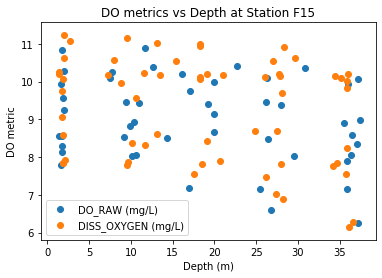

In [81]:
# At one station
raw_data_f15 = raw_df[raw_df['STAT_ID'] == 'F15']
non_raw_data_f15 = non_raw_df[non_raw_df['STAT_ID'] == 'F15']
# Temperature
plt.scatter(raw_data_f15['DEPTH (m)'], raw_data_f15['DO_RAW (mg/L)'], label = 'DO_RAW (mg/L)')
plt.scatter(non_raw_data_f15['DEPTH (m)'], non_raw_data_f15['DISS_OXYGEN (mg/L)'], label = "DISS_OXYGEN (mg/L)")
plt.xlabel("Depth (m)")
plt.ylabel("DO metric")
plt.title("DO metrics vs Depth at Station F15")
plt.legend()

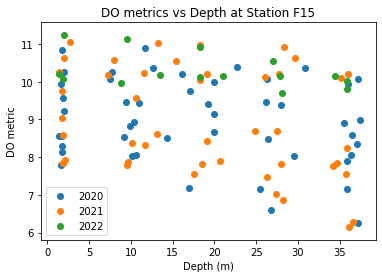

In [15]:
# At one station yearly
y2020_f15 = y2020[y2020['STAT_ID'] == 'F15']
y2021_f15 = y2021[y2021['STAT_ID'] == 'F15']
y2022_f15 = y2022[y2022['STAT_ID'] == 'F15']

plt.scatter(y2020_f15['DEPTH (m)'], y2020_f15['DO_RAW (mg/L)'], label = '2020')
plt.scatter(y2021_f15['DEPTH (m)'], y2021_f15['DISS_OXYGEN (mg/L)'], label = "2021")
plt.scatter(y2022_f15['DEPTH (m)'], y2022_f15['DISS_OXYGEN (mg/L)'], label = "2022")
plt.xlabel("Depth (m)")
plt.ylabel("DO metric")
plt.title("DO metrics vs Depth at Station F15")
plt.legend()

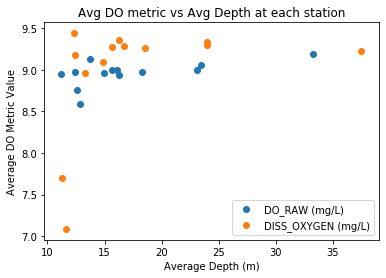

In [82]:
# Average across all common stations, by year
plt.scatter(raw_depth_avg, raw_avg, label = 'DO_RAW (mg/L)')
plt.scatter(non_raw_depth_avg, non_raw_avg, label = "DISS_OXYGEN (mg/L)")
plt.xlabel("Average Depth (m)")
plt.ylabel("Average DO Metric Value")
plt.title("Avg DO metric vs Avg Depth at each station")
plt.legend()

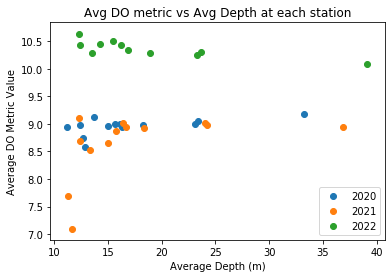

In [19]:
# Average across all common stations, by year
plt.scatter(raw_depth_avg, raw_avg, label = '2020')
plt.scatter(y2021_avg_depth, y2021_avg, label = "2021")
plt.scatter(y2022_avg_depth, y2022_avg, label = "2022")
plt.xlabel("Average Depth (m)")
plt.ylabel("Average DO Metric Value")
plt.title("Avg DO metric vs Avg Depth at each station")
plt.legend()

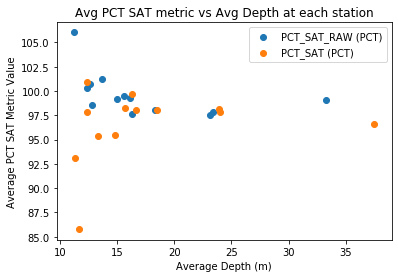

In [83]:
# Average across all common stationas
plt.scatter(raw_depth_avg, raw_avg_pct, label = 'PCT_SAT_RAW (PCT)')
plt.scatter(non_raw_depth_avg, non_raw_avg_pct, label = "PCT_SAT (PCT)")
plt.xlabel("Average Depth (m)")
plt.ylabel("Average PCT SAT Metric Value")
plt.title("Avg PCT SAT metric vs Avg Depth at each station")
plt.legend()

In [65]:
# Correct column mapping inconsistencies in new format
# Drop inconsistent columns
for csv in newcsvs:
    if 'DO_RAW (mg/L)' in newcsvs[csv].columns:
        newcsvs[csv]['DISS_OXYGEN (mg/L)'] = newcsvs[csv]['DO_RAW (mg/L)']
        newcsvs[csv] = newcsvs[csv].drop(columns = ['DO_RAW (mg/L)'])
    if 'PCT_SAT_RAW (PCT)' in newcsvs[csv].columns:
        newcsvs[csv]['PCT_SAT (PCT)'] = newcsvs[csv]['PCT_SAT_RAW (PCT)']
        newcsvs[csv] = newcsvs[csv].drop(columns = ['PCT_SAT_RAW (PCT)'])
        
# Remove extraneous columns in March 2022 data
newcsvs["WN222_Event_dataMar2022.xlsx"] = newcsvs['WN222_Event_dataMar2022.xlsx'].drop(columns = ['Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35'])

In [66]:
# Concat
newconcat = pd.concat(newcsvs, ignore_index=True, sort=False)

In [67]:
# Remove exraneous colulms from concat
newconcat = newconcat.drop(columns = ['COMMENTS'])

In [68]:
# Add data source column
newconcat['Data Source'] = 'MassBay_2020_to_2022_CONCAT'

In [69]:
# Remove space from station col
newconcat['STAT_ID'] = [stat.strip(" ") for stat in newconcat['STAT_ID']]

In [70]:
len(newconcat)

1257

In [71]:
# Convert timestamp to datetime if string
for ind, row in newconcat.iterrows():
    date_str = row['PROF_DATE_TIME_LOCAL']
    if type(date_str) == str:
        newconcat.loc[ind, 'PROF_DATE_TIME_LOCAL'] = dateparser.parse(date_str)

/Users/becklabash/opt/anaconda3/lib/python3.7/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [72]:
# B should be lower than C
# For each row in the DF
for ind, row in newconcat.iterrows():
  if row['SAMPLE_DEPTH_CODE'] == 'B':
    if newconcat.loc[ind + 1, 'SAMPLE_DEPTH_CODE'] == 'C':
      newconcat.loc[ind, 'SAMPLE_DEPTH_CODE'] = 'C'
      newconcat.loc[ind + 1, 'SAMPLE_DEPTH_CODE'] = 'B'

In [16]:
x = 0
for station in all_stations:
    years = {'2020': 0, '2021': 0, '2022': 0}
    for ind, row in newconcat.iterrows():
        if row['STAT_ID'] == station:
            years[row['PROF_DATE_TIME_LOCAL'].strftime("%Y")] += 1
    x += sum(list(years.values()))
    print(station, years)
print(x)

AF4 {'2020': 6, '2021': 5, '2022': 0}
F05 {'2020': 6, '2021': 0, '2022': 0}
N04 {'2020': 48, '2021': 45, '2022': 15}
N10 {'2020': 7, '2021': 5, '2022': 0}
F23 {'2020': 48, '2021': 45, '2022': 15}
AF1 {'2020': 8, '2021': 0, '2022': 0}
F15 {'2020': 48, '2021': 45, '2022': 15}
N21 {'2020': 40, '2021': 45, '2022': 15}
AF6 {'2020': 8, '2021': 0, '2022': 0}
AF9 {'2020': 8, '2021': 0, '2022': 0}
F10 {'2020': 48, '2021': 45, '2022': 15}
F17 {'2020': 8, '2021': 0, '2022': 0}
AF8 {'2020': 8, '2021': 0, '2022': 0}
F06 {'2020': 48, '2021': 45, '2022': 15}
F13 {'2020': 48, '2021': 45, '2022': 15}
N07 {'2020': 48, '2021': 45, '2022': 15}
N18 {'2020': 48, '2021': 45, '2022': 15}
AF2 {'2020': 8, '2021': 0, '2022': 0}
N01 {'2020': 48, '2021': 45, '2022': 15}
F22 {'2020': 48, '2021': 45, '2022': 15}
1257


In [73]:
# Save concat and metadata
newconcat.to_csv('../data/MassBay/NewFormat/concat/MassBay_2020_to_2022_CONCAT_swapped.csv', index=False)

## Merging Old and New Formats

In [74]:
# Read csvs
old_format = pd.read_csv('../data/MassBay/OldFormat/concat/MassBay_2017_to_2019_CONCAT.csv')
new_format = pd.read_csv('../data/MassBay/NewFormat/concat/MassBay_2020_to_2022_CONCAT.csv')

In [146]:
# New to Old Column Mapping (retain new column names)
# EVENT_ID : SampleID
# STAT_ID : StationID
# PROF_DATE_TIME_LOCAL : SampleDateTime
# LATITUDE : Latitude
# LONGITUDE : Longitude
# DEPTH (m): Depth
# CONDTVY (mS/cm): Conductivity
# DISS_OXYGEN (mg/L) : Dissolved Oxygen (Model 43)
# FLU_RAW (ug/L) : Chla Fluor
# PCT_SAT_RAW (PCT) : DO % Saturation
# pH () : pH <2>
# SAL (PSU) : Salinity
# SIGMA_T (): Sigma-T
# TEMP (C) : Temperature
# TRANS (m-1) : Beam Attenuation

In [75]:
new_to_old = {'EVENT_ID' : 'SampleID',
 'STAT_ID' : 'StationID',
 'PROF_DATE_TIME_LOCAL' : 'SampleDateTime',
 'LATITUDE' : 'Latitude',
 'LONGITUDE' : 'Longitude',
 'DEPTH (m)': 'Depth',
 'CONDTVY (mS/cm)': 'Conductivity',
'DISS_OXYGEN (mg/L)' : 'Dissolved Oxygen (Model 43)',
'FLU_RAW (ug/L)' : 'Chla Fluor',
'PCT_SAT (PCT)' : 'DO % Saturation',
'pH ()': 'pH <2>',
 'SAL (PSU)' : 'Salinity',
'SIGMA_T ()': 'Sigma-T',
 'TEMP (C)' : 'Temperature',
'TRANS (m-1)' : 'Beam Attenuation'}

In [76]:
old_converted = old_format.copy()
for new_col in new_to_old:
    old_converted[new_col] = old_converted[new_to_old[new_col]]
    old_converted = old_converted.drop(columns = [new_to_old[new_col]])

In [77]:
oldAndNew = pd.concat([new_format, old_converted], ignore_index=True, sort=False)

In [78]:
oldAndNew['Data Source'] = 'MassBay_2017_to_2022'

In [79]:
type(oldAndNew['PROF_DATE_TIME_LOCAL'][2745])

str

In [80]:
# Check dates correct
for ind, row in oldAndNew.iterrows():
    date = dateparser.parse(row['PROF_DATE_TIME_LOCAL'])
    try:
        x = date.strftime("%Y")
        if not x in ["2017", "2018", "2019", "2020", "2021", "2022"]:
            print(date_str)
    except:
        print(date_str)
    oldAndNew.loc[ind, 'PROF_DATE_TIME_LOCAL'] = date

In [81]:
eastern = timezone("US/Eastern")
# Drop microseconds and set timezone
oldAndNew['PROF_DATE_TIME_LOCAL'] = [date.replace(microsecond=0).replace(tzinfo=eastern) for date in oldAndNew['PROF_DATE_TIME_LOCAL']]

#Convert to excel parsable string
oldAndNew['PROF_DATE_TIME_LOCAL'] = [date.strftime("%Y-%m-%d %H:%M:%S%z") for date in oldAndNew['PROF_DATE_TIME_LOCAL']]

In [83]:
oldAndNew.to_csv('../data/MassBay/concat/MassBay_2017_to_2022_swapped.csv', index = False)

In [127]:
def print_column_descriptions(df):
    ind = 1
    for col in df.columns:
        print(f'Column {ind}: {col} is COLUMN DESCRIPTION   BAD FLAG : -1.E+34')
        ind += 1

# Using MWRA provided 2017 - 2022 file Instead

In [59]:
old_concat = pd.read_csv('../data/MassBay/concat/MassBay_2017_to_2022.csv')
mwra_batch = pd.read_excel('../data/MassBay/concat/Copy of WN17x_to_WN22x_Event_Data.xlsx')

In [60]:
# Inject val qual column into mwra batch
# Get all non-null 
concat_with_val_qual = old_concat[old_concat['VAL_QUAL'].notnull()]

# Iterate over the rows with a val_qual defined
for ind, row in concat_with_val_qual.iterrows():

  # Get comparator columns
  val_qual = row['VAL_QUAL']
  lat = row['LATITUDE']
  lon = row['LONGITUDE']
  depth = row['DEPTH (m)']
  cond = row['CONDTVY (mS/cm)']
  
  # Get matching row in mwra batch
  match_row = mwra_batch[
    (mwra_batch['LATITUDE'] == lat)
  & (mwra_batch['LONGITUDE'] == lon)
  & (mwra_batch['DEPTH (m)'] == depth)
  & (mwra_batch['CONDTVY (mS/cm)'] == cond)]

  if (len(match_row) != 1):
    print("Couldn't find 1 to 1 match")

  match_ind = match_row.index.values[0]

  # Add this val qual to the matching row
  mwra_batch.loc[match_ind, 'VAL_QUAL'] = val_qual
  

In [61]:
# Merge DISS_OXYGEN (mg/L)	DO_RAW (mg/L) PCT_SAT (PCT)	PCT_SAT_RAW (PCT)
mwra_batch['DO_RAW (mg/L)'] = mwra_batch['DO_RAW (mg/L)'].fillna(mwra_batch['DISS_OXYGEN (mg/L)'])
mwra_batch['PCT_SAT_RAW (PCT)'] = mwra_batch['PCT_SAT_RAW (PCT)'].fillna(mwra_batch['PCT_SAT (PCT)'])

# Drop DISS_OXYGEN (mg/L), PCT_SAT_RAW (PCT)
mwra_batch.drop(columns=[
  'DISS_OXYGEN (mg/L)',
   'PCT_SAT (PCT)',
   'depth_code_sort',
   'depth_SORT',
   'Depths_Flipped'
   ], inplace=True)

# Add metadata column
mwra_batch['Data Source'] = 'MassBay_2017_to_2022'

# Add timezone
eastern = timezone('US/Eastern')
mwra_batch['PROF_DATE_TIME_LOCAL'] = [date.replace(microsecond=0).replace(tzinfo=eastern) for date in mwra_batch['PROF_DATE_TIME_LOCAL']]

#Convert to excel parsable string
mwra_batch['PROF_DATE_TIME_LOCAL'] = [date.strftime("%Y-%m-%d %H:%M:%S%z") for date in mwra_batch['PROF_DATE_TIME_LOCAL']]

In [63]:
# Save
mwra_batch.to_csv('../data/MassBay/concat/MassBay_2017_to_2022_batch.csv', index=False)

In [21]:
mwra_batch = pd.read_csv('../data/MassBay/MWRA_MassBay_upcast_2017-202205.csv')
all_stations = mwra_batch['STAT_ID'].unique()
x = 0
for station in all_stations:
    years = {'2017': 0, '2018': 0, '2019': 0,'2020': 0, '2021': 0, '2022': 0}
    for ind, row in mwra_batch.iterrows():
        if row['STAT_ID'] == station:
          years[row['STAT_ARRIV'][7:11]] += 1
    x += sum(list(years.values()))
    print(station, years)
print(x)

F13 {'2017': 60, '2018': 45, '2019': 71, '2020': 48, '2021': 55, '2022': 20}
F06 {'2017': 61, '2018': 45, '2019': 73, '2020': 48, '2021': 57, '2022': 20}
F10 {'2017': 61, '2018': 45, '2019': 73, '2020': 48, '2021': 57, '2022': 20}
F15 {'2017': 61, '2018': 45, '2019': 73, '2020': 48, '2021': 57, '2022': 20}
N07 {'2017': 61, '2018': 45, '2019': 73, '2020': 48, '2021': 57, '2022': 20}
N18 {'2017': 59, '2018': 45, '2019': 70, '2020': 48, '2021': 56, '2022': 20}
N21 {'2017': 45, '2018': 45, '2019': 45, '2020': 40, '2021': 45, '2022': 20}
F22 {'2017': 61, '2018': 45, '2019': 73, '2020': 48, '2021': 57, '2022': 20}
N04 {'2017': 61, '2018': 45, '2019': 73, '2020': 48, '2021': 57, '2022': 20}
N01 {'2017': 61, '2018': 45, '2019': 73, '2020': 48, '2021': 57, '2022': 20}
F23 {'2017': 59, '2018': 45, '2019': 64, '2020': 48, '2021': 55, '2022': 20}
AF2 {'2017': 16, '2018': 0, '2019': 28, '2020': 8, '2021': 12, '2022': 0}
F17 {'2017': 16, '2018': 0, '2019': 28, '2020': 8, '2021': 12, '2022': 0}
AF6 {

### Add missing data to MWRA upcast

In [75]:
mwra = pd.read_csv('../data/MassBay/MWRA_MassBay_upcast_2017-202205.csv')
mwra_batch = pd.read_csv('../data/MassBay/concat/MassBay_2017_to_2022_batch.csv')

In [76]:
# Get lat long from batch into upcast
matches = 0
no_match = 0
overlaps = 0
rows = []

#ph_nulls = list(mwra['PH'].isnull())
print(pd.isnull(mwra.loc[6, 'PH']))
# Add sample codes and dates to seagrant
for ind, row in mwra.iterrows():
  cond = row['CONDTVY']
  do2 = row['DISS_OXYGEN']
  flu = row['FLU_RAW']
  ph = row['PH']
  depth = row['PROFILE_DEPTH']
  sigma_t = row['SIGMA_T']
  temp = row['TEMP']


  # Get matching row in mwra batch
  match_row = mwra_batch[
  (abs(mwra_batch['DEPTH (m)'] - depth) <=  0.01)
  & (abs(mwra_batch['TEMP (C)'] - temp) <= 0.01)
  #& ((abs(mwra_batch['FLU_RAW (ug/L)'] - flu) <= 0.01) | pd.isnull(mwra_batch['FLU_RAW (ug/L)']))
  & (abs(mwra_batch['SIGMA_T ()'] - sigma_t) <= 0.01)
  ]
  

  if (len(match_row) == 1):
    matches += 1
    rows.append(match_row.iloc[[0]])

  if (len(match_row) < 1):
    no_match += 1
  if (len(match_row) > 1):
    overlaps += 1


  if len(match_row) == 1:
    match_ind = match_row.index.values[0]

    mwra.loc[ind, 'LATITUDE'] = mwra_batch['LATITUDE'][match_ind]
    mwra.loc[ind, 'LONGITUDE'] = mwra_batch['LONGITUDE'][match_ind]
    if pd.isnull(mwra.loc[ind, 'PH']):
      mwra.loc[ind, 'PH'] = mwra_batch['pH ()'][match_ind]
      mwra.loc[ind, 'VAL_QUAL'] = -1

print("Mathes:", matches)
print("No Matches:", no_match)
print("Overlaps:", overlaps)

False
Mathes: 2658
No Matches: 1152
Overlaps: 0


In [ ]:
# Difference between seagrant and mwra
#concat_rows = pd.concat(rows)
#print(concat_rows.shape)
#print(mwra_batch.shape)
#print(pd.concat([concat_rows,mwra_batch]).drop_duplicates(keep=False))

In [77]:
# Save as csv
mwra['Data Source'] = 'MWRA_MassBay_upcast_2017-202205'
mwra.to_csv('../data/MassBay/concat/MassBay_2017_to_2022_upcast_update.csv', index=False)

# Concatenating MWRA and SeaGrant data

In [49]:
import pandas as pd
mwra = pd.read_csv('../data/MassBay/concat/MassBay_2017_to_2022_upcast_update.csv')
seagrant = pd.read_csv('../data/SeaGrant-TA_DIC-MassBayData/concat/ToRies_Labprocessed2017_to_2021_test.csv')

In [50]:
# Define column mappings
mwra_to_upcast_mwra = {
 'PROF_DATE_TIME_LOCAL' : 'STAT_ARRIV',
 'SAMPLE_DEPTH_CODE': 'DEPTH_MARKER',
 'DEPTH (m)': 'PROFILE_DEPTH',
 'CONDTVY (mS/cm)': 'CONDTVY',
'DISS_OXYGEN (mg/L)' : 'DISS_OXYGEN',
'FLUORESCENCE (ug/L)' : 'FLUORESCENCE',
'FLU_RAW (ug/L)' : 'FLU_RAW',
'PCT_SAT (PCT)' : 'PCT_SAT',
'pH ()': 'PH',
 'SAL (PSU)' : 'SAL',
'SIGMA_T ()': 'SIGMA_T',
 'TEMP (C)' : 'TEMP',
'TRANS (m-1)' : 'TRANS'}

mwra_to_seagrant = {'EVENT_ID' : 'SampleID',
 'STAT_ID' : 'StationID',
 'PROF_DATE_TIME_LOCAL' : 'SampleDateTime',
 'LATITUDE' : 'Latitude',
 'LONGITUDE' : 'Longitude',
 'DEPTH (m)': 'Depth',
 'CONDTVY (mS/cm)': 'Conductivity',
'DISS_OXYGEN (mg/L)' : 'Dissolved Oxygen (Model 43)',
'FLU_RAW (ug/L)' : 'Chla Fluor',
'PCT_SAT (PCT)' : 'DO % Saturation',
'pH ()': 'pH <2>',
 'SAL (PSU)' : 'Salinity',
'SIGMA_T ()': 'Sigma-T',
 'TEMP (C)' : 'Temperature',
'TRANS (m-1)' : 'Beam Attenuation'}

In [51]:
# Apply column mappings
for mwra_col in mwra_to_upcast_mwra:
  mwra[mwra_col] = mwra[mwra_to_upcast_mwra[mwra_col]]
  mwra.drop(mwra_to_upcast_mwra[mwra_col], axis=1, inplace=True)

for mwra_col in mwra_to_seagrant:
    seagrant[mwra_col] = seagrant[mwra_to_seagrant[mwra_col]]
    seagrant.drop([mwra_to_seagrant[mwra_col]], axis=1, inplace=True)

In [52]:
# Add a DATETIME column for comparison

# Upcast date format: mytime.strftime("%d-%^b-%Y %H:%M:%S")
for ind, row in mwra.iterrows():
  date = datetime.datetime.strptime(row['PROF_DATE_TIME_LOCAL'], "%d-%b-%Y %H:%M:%S")
  mwra.loc[ind, 'DATETIME'] = date

# Seagrant date format: 
for ind, row in seagrant.iterrows():
  string = row['PROF_DATE_TIME_LOCAL'].split('/')
  year = int(string[2].split(" ")[0])
  month = int(string[0])
  day = int(string[1])
  hour = int(string[2].split(" ")[1].split(":")[0])
  minute = int(string[2].split(" ")[1].split(":")[1])
  date = datetime.datetime(year, month, day, hour, minute)
  seagrant.loc[ind, 'DATETIME'] = date

In [53]:
# DIC TO UPCAST MATCHING
# Add sample codes and dates to seagrant
matches  = 0
no_match = 0
overlaps = 0
samples = []
for ind, row in seagrant.iterrows():
  depth = row['DEPTH (m)']
  lat = row['LATITUDE']
  lon = row['LONGITUDE']

  match_row = mwra[
  (abs(mwra['DEPTH (m)'] - depth) <= 3)
  & (abs(mwra['LATITUDE'] - lat) <= 0.000001)
  & (abs(mwra['LONGITUDE'] - lon) <= 0.000001)
  ]

  #Match ind
  

  if (len(match_row) == 1):
    match_ind = match_row.index.values[0]
    matches += 1
    samples.append(row['EVENT_ID'])
    
    # mwra['DATETIME'][match_ind]

    for mwra_col in mwra.columns:
      if not pd.isnull(mwra[mwra_col][match_ind]):
        seagrant.loc[ind, mwra_col] = mwra.loc[match_ind, mwra_col]
      
    #seagrant.loc[ind, 'DATETIME'] = mwra.loc[match_ind, 'DATETIME']
  
    #seagrant.loc[ind, 'DEPTH (m)'] =  mwra.loc[match_ind, 'DEPTH (m)']

    #seagrant.loc[ind, 'LATITUDE'] = mwra.loc[match_ind, 'LATITUDE']

    #seagrant.loc[ind, 'LONGITUDE'] = mwra.loc[match_ind, 'LONGITUDE']

    #seagrant.loc[ind, 'SAMPLE_DEPTH_CODE'] = mwra['SAMPLE_DEPTH_CODE'][match_ind]

    #if seagrant.loc[ind, 'pH ()'].isnull():
      #seagrant.loc[ind, 'pH ()'] = mwra.loc[match_ind, 'pH ()']
      
  if (len(match_row) < 1):
    no_match += 1
  if (len(match_row) > 1):
    overlaps += 1

print("Matches:", matches)
print("No Matches:", no_match)
print("Overlaps:", overlaps)

samples2 = []
# Select rows that have the string "WN" in the EVENT_ID column
for ind, row in seagrant.iterrows():
  if type(row['EVENT_ID'])  == str:
    if "WN" in row['EVENT_ID']:
      samples2.append(row['EVENT_ID'])

print(len(samples2))
print(len(samples))


Matches: 318
No Matches: 172
Overlaps: 0
318
318


In [54]:
combined = pd.concat([mwra, seagrant], ignore_index=True, sort=False)

In [55]:
mwra.columns

Index(['STUDY_ID', 'EVENT_ID', 'STAT_ID', 'ORDERED_DEPTH_CODE', 'SAMPLE_ID',
       'SAMPLE_DEPTH_TOP', 'SAMPLE_DEPTH_BOTTOM', 'LATITUDE', 'LONGITUDE',
       'VAL_QUAL', 'Data Source', 'PROF_DATE_TIME_LOCAL', 'SAMPLE_DEPTH_CODE',
       'DEPTH (m)', 'CONDTVY (mS/cm)', 'DISS_OXYGEN (mg/L)',
       'FLUORESCENCE (ug/L)', 'FLU_RAW (ug/L)', 'PCT_SAT (PCT)', 'pH ()',
       'SAL (PSU)', 'SIGMA_T ()', 'TEMP (C)', 'TRANS (m-1)', 'DATETIME'],
      dtype='object')

In [45]:
# Retrieve MWRA rows that are not in DIC data
no_dupes = combined.drop_duplicates(subset = ['LATITUDE', 'LONGITUDE', 'DEPTH (m)'], keep = 'last')
mwra_no_dupes = no_dupes[no_dupes['Data Source'] == 'MWRA_MassBay_upcast_2017-202205']

In [46]:
# Concatenate these rows with DIC data
concat = pd.concat([mwra_no_dupes, seagrant], ignore_index=True, sort=False)

In [47]:
# Strip station ID spaces
#concat['STAT_ID'] = [stat.strip(" ") for stat in concat['STAT_ID']]
for ind, row in concat.iterrows():
    if type(row['STAT_ID']) == str:
        concat.loc[ind, 'STAT_ID'] = row['STAT_ID'].strip(" ")

In [48]:
concat.sort_values(by='DATETIME', inplace=True)
concat['PROF_DATE_TIME_LOCAL'] = concat['DATETIME'].dt.strftime("%-m/%d/%y %H:%M")
# Drop the datetime column
concat.drop('DATETIME', axis=1, inplace=True)
concat.to_csv('../data/concat/MWRA_TA_DIC_2017_to_2022_test.csv', index = False)

#### Add target lat lon

In [3]:
# Adding missing station data
concat  = pd.read_csv('../data/concat/MWRA_TA_DIC_2017_to_2022.csv')
print(len(concat[concat['LATITUDE'].isnull()]))
station_defined = concat[((concat['STAT_ID'].notnull()) & (concat['LATITUDE'].isnull())) & (concat['LONGITUDE'].isnull())]

     STUDY_ID EVENT_ID STAT_ID ORDERED_DEPTH_CODE SAMPLE_ID  SAMPLE_DEPTH_TOP  \
314      ARRS    AF171     AF2                  E  AF171027             37.80   
315      ARRS    AF171     F06                  E  AF17103F             30.43   
316      ARRS    AF171     F10                  E  AF17104B             33.42   
317      ARRS    AF171     F17                  E  AF171058             78.15   
318      ARRS    AF171     AF6                  E  AF171066             88.51   
...       ...      ...     ...                ...       ...               ...   
3507      NaN       CC     HAR                NaN       NaN               NaN   
3508      NaN       CC     HAR                NaN       NaN               NaN   
3509      NaN       CC     HAR                NaN       NaN               NaN   
3510      NaN       CC    NFAL                NaN       NaN               NaN   
3511      NaN       CC    NFAL                NaN       NaN               NaN   

      SAMPLE_DEPTH_BOTTOM  

In [2]:
# Station ID, Target latitude, Target longitude
stations  = pd.read_csv('../data/MassBay/MWRA_MassBay_metadata.xlsx - Station locations.csv')
stations.set_index('Station ID', inplace=True)


for ind, row in station_defined.iterrows():
  station = row['STAT_ID']
  if station in stations.index :
    station_defined.loc[ind, 'LATITUDE'] = stations.loc[station, 'Target latitude']
    station_defined.loc[ind, 'LONGITUDE'] = stations.loc[station, 'Target longitude']
print(concat[concat['LATITUDE'].isnull()])


     STUDY_ID EVENT_ID STAT_ID ORDERED_DEPTH_CODE SAMPLE_ID  SAMPLE_DEPTH_TOP  \
314      ARRS    AF171     AF2                  E  AF171027             37.80   
315      ARRS    AF171     F06                  E  AF17103F             30.43   
316      ARRS    AF171     F10                  E  AF17104B             33.42   
317      ARRS    AF171     F17                  E  AF171058             78.15   
318      ARRS    AF171     AF6                  E  AF171066             88.51   
...       ...      ...     ...                ...       ...               ...   
3507      NaN       CC     HAR                NaN       NaN               NaN   
3508      NaN       CC     HAR                NaN       NaN               NaN   
3509      NaN       CC     HAR                NaN       NaN               NaN   
3510      NaN       CC    NFAL                NaN       NaN               NaN   
3511      NaN       CC    NFAL                NaN       NaN               NaN   

      SAMPLE_DEPTH_BOTTOM  

KeyError: "None of ['Station ID'] are in the columns"

In [93]:
concat.to_csv('../data/concat/MWRA_TA_DIC_2017_to_2022.csv', index = False)

In [3]:
import pandas as pd
# Concat metadata file
def print_column_descriptions(df):
    ind = 1
    for col in df.columns:
        print(f'Column {ind}: {col} is COLUMN DESCRIPTION')
        ind += 1
print_column_descriptions(pd.read_csv('../data/concat/MWRA_TA_DIC_2017_to_2022.csv'))

Column 1: STUDY_ID is COLUMN DESCRIPTION
Column 2: EVENT_ID is COLUMN DESCRIPTION
Column 3: STAT_ID is COLUMN DESCRIPTION
Column 4: ORDERED_DEPTH_CODE is COLUMN DESCRIPTION
Column 5: SAMPLE_ID is COLUMN DESCRIPTION
Column 6: SAMPLE_DEPTH_TOP is COLUMN DESCRIPTION
Column 7: SAMPLE_DEPTH_BOTTOM is COLUMN DESCRIPTION
Column 8: FLUORESCENCE is COLUMN DESCRIPTION
Column 9: LATITUDE is COLUMN DESCRIPTION
Column 10: LONGITUDE is COLUMN DESCRIPTION
Column 11: VAL_QUAL is COLUMN DESCRIPTION
Column 12: Data Source is COLUMN DESCRIPTION
Column 13: PROF_DATE_TIME_LOCAL is COLUMN DESCRIPTION
Column 14: SAMPLE_DEPTH_CODE is COLUMN DESCRIPTION
Column 15: DEPTH (m) is COLUMN DESCRIPTION
Column 16: CONDTVY (mS/cm) is COLUMN DESCRIPTION
Column 17: DISS_OXYGEN (mg/L) is COLUMN DESCRIPTION
Column 18: FLU_RAW (ug/L) is COLUMN DESCRIPTION
Column 19: PCT_SAT (PCT) is COLUMN DESCRIPTION
Column 20: pH () is COLUMN DESCRIPTION
Column 21: SAL (PSU) is COLUMN DESCRIPTION
Column 22: SIGMA_T () is COLUMN DESCRIPTIO

### Summary Map CSV creation

In [265]:
# Strip station ID spaces
i = 0
for ind, row in no_dupes.iterrows():
    if type(row['STAT_ID']) == str:
        no_dupes.loc[ind, 'STAT_ID'] = row['STAT_ID'].strip(" ")

In [2]:
import pandas as pd
no_dupes = pd.read_csv('resolved_stations.csv')
#Split by year and save each as a csv in the resolved_split folder
for year in range(2017,2022):
    year_split = no_dupes[no_dupes['PROF_DATE_TIME_LOCAL'].str.contains(str(year))]
    year_split.to_csv(f'resolved_split/MWRA_seagrant_concat_{year}.csv', index = False)

In [271]:
y2017 = pd.DataFrame(columns = no_dupes.columns)
y2018 = pd.DataFrame(columns = no_dupes.columns)
y2019 = pd.DataFrame(columns = no_dupes.columns)
y2020 = pd.DataFrame(columns = no_dupes.columns)
y2021 = pd.DataFrame(columns = no_dupes.columns)
y2022 = pd.DataFrame(columns = no_dupes.columns)

# Split data by year without replicates
for ind, row in no_dupes.iterrows():
    year = datetime.datetime.strptime(row['PROF_DATE_TIME_LOCAL'], "%Y-%m-%d %H:%M:%S%z").strftime("%Y")
    if year == "2017":
        y2017.loc[len(y2017.index)] = row
    elif year == "2018":
        y2018.loc[len(y2018.index)] = row
    elif year == "2019":
        y2019.loc[len(y2019.index)] = row
    elif year == "2020":
        y2020.loc[len(y2020.index)] = row
    elif year == "2021":
        y2021.loc[len(y2021.index)] = row
    elif year == "2022":
        y2022.loc[len(y2022.index)] = row

In [279]:
y2017.to_csv('y2017_summary.csv')
y2018.to_csv('y2018_summary.csv')
y2019.to_csv('y2019_summary.csv')
y2020.to_csv('y2020_summary.csv')
y2021.to_csv('y2021_summary.csv')
y2022.to_csv('y2022_summary.csv')



In [275]:
no_invalid_dates = no_dupes.dropna(subset=['PROF_DATE_TIME_LOCAL'])

In [278]:
no_invalid_dates.to_csv('unique_data_dates.csv')